In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


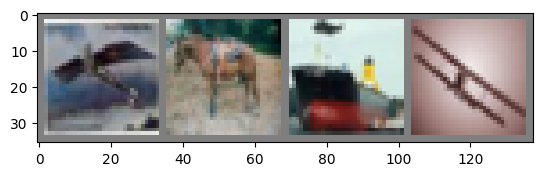

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
images.shape

torch.Size([4, 3, 32, 32])

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


In [12]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            print('Finished Training')


Epoch [1/5], Step [2000/12500], Loss: 2.3174
Finished Training
Epoch [1/5], Step [4000/12500], Loss: 2.2966
Finished Training
Epoch [1/5], Step [6000/12500], Loss: 2.2105
Finished Training
Epoch [1/5], Step [8000/12500], Loss: 2.3393
Finished Training
Epoch [1/5], Step [10000/12500], Loss: 1.9147
Finished Training
Epoch [1/5], Step [12000/12500], Loss: 2.2741
Finished Training
Epoch [2/5], Step [2000/12500], Loss: 1.9552
Finished Training
Epoch [2/5], Step [4000/12500], Loss: 2.1423
Finished Training
Epoch [2/5], Step [6000/12500], Loss: 1.4109
Finished Training
Epoch [2/5], Step [8000/12500], Loss: 1.8265
Finished Training
Epoch [2/5], Step [10000/12500], Loss: 1.9832
Finished Training
Epoch [2/5], Step [12000/12500], Loss: 2.0833
Finished Training
Epoch [3/5], Step [2000/12500], Loss: 1.5675
Finished Training
Epoch [3/5], Step [4000/12500], Loss: 2.5222
Finished Training
Epoch [3/5], Step [6000/12500], Loss: 1.5851
Finished Training
Epoch [3/5], Step [8000/12500], Loss: 1.6691
Finish

In [13]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Accuracy of the network: 49.51 %
Accuracy of plane: 52.1 %
Accuracy of car: 64.7 %
Accuracy of bird: 30.4 %
Accuracy of cat: 39.8 %
Accuracy of deer: 35.4 %
Accuracy of dog: 38.4 %
Accuracy of frog: 63.0 %
Accuracy of horse: 51.4 %
Accuracy of ship: 66.3 %
Accuracy of truck: 53.6 %


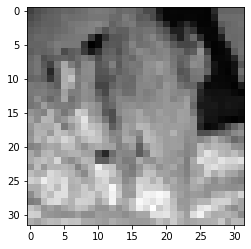

In [16]:
npimg=images.numpy()
npimg.shape
img_A=npimg[0,:,:,:]
img_gray=0.299*img_A[0,:,:]+0.587*img_A[1,:,:]+0.114*img_A[2,:,:]
plt.imshow(img_gray,cmap='gray')

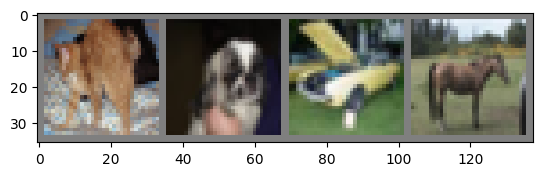

labels= tensor([3, 5, 1, 7])


tensor([[-1.7701, -2.9111,  0.1575,  2.0153,  1.4663,  1.5084,  1.5702,  0.5876,
         -2.4103, -2.4399],
        [-2.6227, -4.4419,  0.7602,  2.4006,  1.2450,  2.6151, -0.4262,  2.1773,
         -4.0872, -2.3778],
        [ 0.3264, -0.0237,  0.1828, -0.1363,  0.6114,  0.0654, -0.9376,  0.0596,
         -1.8222, -1.2810],
        [-0.8250, -2.4507,  0.1839, -0.0656,  1.4601,  0.2959,  0.1178,  2.6489,
         -2.8319, -0.8634]], grad_fn=<AddmmBackward0>)

In [22]:
imshow(torchvision.utils.make_grid(images))
print("labels=",labels)
model(images)

In [28]:
_, pred = torch.max(model(images), 1)
print(_)
print("pred=",pred)
(pred == labels).sum().item()

tensor([2.0153, 2.6151, 0.6114, 2.6489], grad_fn=<MaxBackward0>)
pred= tensor([3, 5, 4, 7])


3

In [81]:
class compute_metrics():
    def __init__(self):
        pass
    
    @staticmethod
    def accuracy(model,data_loader):
        true_prediction =0 
        number_samples = 0
        with torch.no_grad():
            for images, labels in data_loader:
                #images = images.view(-1,28*28)
                prediction = model(images)
                predicted_labels = torch.argmax(prediction, 1)
                true_prediction=true_prediction+((predicted_labels==labels)*1).sum()
                number_samples=number_samples+labels.size(0)
        print(true_prediction,number_samples)
        return true_prediction.float()/number_samples * 100


In [82]:
compute_metrics.accuracy(model,test_loader)

tensor(5002) 10000


tensor(50.0200)

In [71]:
# Gradient for an image
a = torch.Tensor([[1, 0, -1],
[2, 0, -2],
[1, 0, -1]])
a=a.repeat(1,3,1,1)

#a = a.view((1,1,3,3))
#a[:,1,:,:]=a[:,0,:,:]
G_x = F.conv2d(images, a,padding=1)

b = torch.Tensor([[1, 2, 1],
[0, 0, 0],
[-1, -2, -1]])

b = b.view((1,1,3,3))
b=b.repeat(1,3,1,1)
G_y = F.conv2d(images, b,padding=1)

G = torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))

In [72]:
G=G.repeat(1,3,1,1)

In [74]:
print(labels)

tensor([3, 5, 1, 7])


In [75]:
print(model(images))

tensor([[-1.2922, -2.4856,  1.1827,  3.2369,  1.6529,  1.9866,  3.5043,  0.8624,
         -3.5273, -2.4638],
        [-1.7712, -3.7955,  1.9998,  4.0394,  1.3059,  4.3266,  0.5741,  3.6789,
         -4.1549, -1.5182],
        [ 0.6251,  0.7777,  1.0553,  1.2447,  0.9334,  0.8647, -0.3448,  0.5471,
         -1.9279, -0.4472],
        [-0.6755, -2.3313, -0.0943,  0.5737,  0.9433,  0.6983,  0.1462,  3.7895,
         -2.8341, -0.0469]], grad_fn=<AddmmBackward0>)


In [76]:
predicted = torch.max(model(images), 1)

In [77]:
predicted

torch.return_types.max(
values=tensor([3.5043, 4.3266, 1.2447, 3.7895], grad_fn=<MaxBackward0>),
indices=tensor([6, 5, 3, 7]))

In [84]:
alpha=0.1
torch.max(model(images+alpha*G), 1)

torch.return_types.max(
values=tensor([4.2900, 6.4086, 2.6055, 4.7225], grad_fn=<MaxBackward0>),
indices=tensor([3, 5, 3, 7]))

In [85]:
labels

tensor([3, 5, 1, 7])

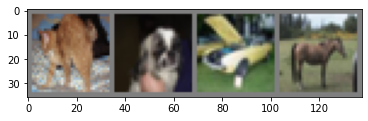

In [83]:
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


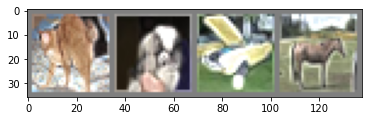

In [86]:
imshow(torchvision.utils.make_grid(images+alpha*G))